# Task 09 - Support Vector Machines (SVM) for Non-linear Classification
## Pattern Recognition and Machine Learning

In [1]:
%load_ext autoreload
%autoreload 2
# uncomment following for interactive matplotlib
# %matplotlib notebook

from svm2 import *
import numpy as np
import matplotlib.pyplot as plt

# Part 1: Kernel SVM
## Test on trivial data

In [2]:
X = np.array([[1, 2, 1, -1, -1, -2], [1, 1, 2, -1, -2, -1]])
y = np.array([1, 1, 1, -1, -1, -1])

### get_kernel function

[[ 2  3  3 -2 -3 -3]
 [ 3  5  4 -3 -4 -5]
 [ 3  4  5 -3 -5 -4]
 [-2 -3 -3  2  3  3]
 [-3 -4 -5  3  5  4]
 [-3 -5 -4  3  4  5]]


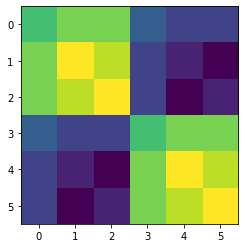

In [3]:
K = get_kernel(X, X, {'kernel': 'linear'})
print(K)
plt.imshow(K, cmap='viridis');

[[ 9 16 16  1  4  4]
 [16 36 25  4  9 16]
 [16 25 36  4 16  9]
 [ 1  4  4  9 16 16]
 [ 4  9 16 16 36 25]
 [ 4 16  9 16 25 36]]


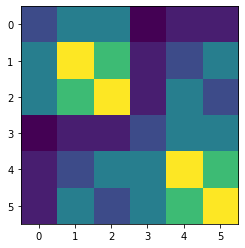

In [4]:
K = get_kernel(X, X, {'kernel': 'polynomial', 'd': 2})
print(K)
plt.imshow(K, cmap='viridis');

[[1.     0.6065 0.6065 0.0183 0.0015 0.0015]
 [0.6065 1.     0.3679 0.0015 0.0001 0.    ]
 [0.6065 0.3679 1.     0.0015 0.     0.0001]
 [0.0183 0.0015 0.0015 1.     0.6065 0.6065]
 [0.0015 0.0001 0.     0.6065 1.     0.3679]
 [0.0015 0.     0.0001 0.6065 0.3679 1.    ]]


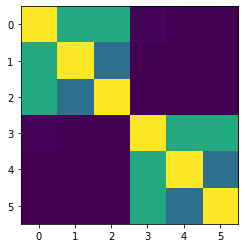

In [5]:
K = get_kernel(X, X, {'kernel': 'rbf', 'sigma': 1.0})
np.set_printoptions(precision=4, suppress=True)
print(K)
np.set_printoptions()
plt.imshow(K, cmap='viridis');

### my_kernel_svm function

In [6]:
y = np.array([-1, 1, 1, 1, -1, -1])
C = float('inf');
options = {'verb': True, 't_max': float('inf'),
           'kernel': 'rbf', 'sigma': 0.01}

In [7]:
model = my_kernel_svm(X, y, C, options)
print(model)

t=1, KKTviol=2.000000, tau=1.000000, tau_lb=0.000000, tau_ub=inf, Q_P=-1.000000
t=2, KKTviol=2.000000, tau=1.000000, tau_lb=0.000000, tau_ub=inf, Q_P=-2.000000
t=3, KKTviol=2.000000, tau=1.000000, tau_lb=0.000000, tau_ub=inf, Q_P=-3.000000
{'sv': array([[ 1,  2,  1, -1, -1, -2],
       [ 1,  1,  2, -1, -2, -1]]), 'y': array([-1,  1,  1,  1, -1, -1]), 'alpha': array([1., 1., 1., 1., 1., 1.]), 'options': {'verb': True, 't_max': inf, 'kernel': 'rbf', 'sigma': 0.01}, 'b': 0.0, 'fun': <function classif_kernel_svm at 0x7f2ad0628e18>}


In [8]:
classif = classif_kernel_svm(X, model)
print(classif)

[-1.  1.  1.  1. -1. -1.]


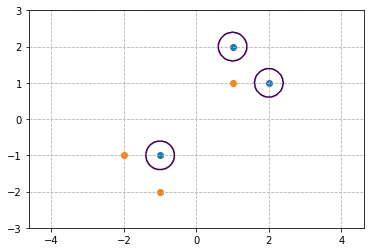

In [9]:
plot_points(X, y)
plt.axis('equal')
plt.grid(linestyle='--')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plot_boundary(plt.gca(), model)


## Test on flower

In [10]:
data = np.load("flower.npz", allow_pickle=True)
X = data["X"]
y = data["y"]

### RBF

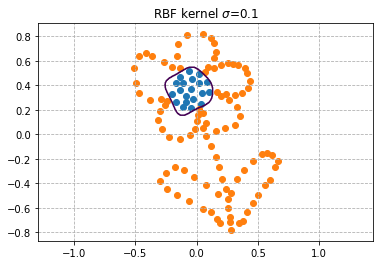

In [11]:
C = 10
sigma = 0.1
options = {'verb': False, 't_max': float('inf'),
           'kernel': 'rbf', 'sigma': sigma}
 
model = my_kernel_svm(X, y, C, options)
plot_points(X, y)
plt.axis('equal')
plt.grid(linestyle='--')
plt.title('RBF kernel $\sigma$={}'.format(sigma))
plot_boundary(plt.gca(), model)
plt.savefig('flower_rbf.png')

### Polynomial

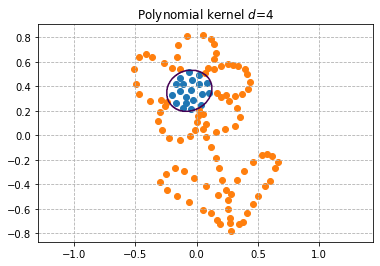

In [12]:
C = 10000
d = 4
options = {'verb': False, 't_max': float('inf'),
           'kernel': 'polynomial', 'd': d}
 
model = my_kernel_svm(X, y, C, options)
plot_points(X, y)
plt.axis('equal')
plt.grid(linestyle='--')
plt.title('Polynomial kernel $d$={}'.format(d))
plot_boundary(plt.gca(), model)
plt.savefig('flower_polynomial.png')

# Part 2: Model selection

In [13]:
data = np.load("ocr_data_2D_trn.npz", allow_pickle=True)
X_trn = data['X']
y_trn = data['y']

In [14]:
np.random.seed(42)
trn_folds, tst_folds = crossval(y_trn.size, num_folds=4)
Cs = [0.0001 ,0.001, 0.01, 0.1]
ds = [5, 10, 15]

best_params = None
best_err = np.inf
for C in Cs:
    for d in ds:
        options = {'verb': False, 't_max': float('inf'),
                  'kernel': 'polynomial', 'd': d}
        err = compute_kernel_test_error(trn_folds, tst_folds, X_trn, y_trn, C, options)

        if err < best_err:
            best_err = err
            best_params = (C, d)
        print('C {}, d {} -> err {}'.format(C, d, err))

print('best params: C={}, d={}'.format(best_params[0], best_params[1]))

C 0.0001, d 5 -> err 0.655
C 0.0001, d 10 -> err 0.11555555555555555
C 0.0001, d 15 -> err 0.09944444444444445
C 0.001, d 5 -> err 0.15277777777777776
C 0.001, d 10 -> err 0.10111111111111112
C 0.001, d 15 -> err 0.07666666666666666
C 0.01, d 5 -> err 0.10944444444444444
C 0.01, d 10 -> err 0.07833333333333334
C 0.01, d 15 -> err 0.15
C 0.1, d 5 -> err 0.08111111111111112
C 0.1, d 10 -> err 0.14500000000000002
C 0.1, d 15 -> err 0.14388888888888887
best params: C=0.001, d=15


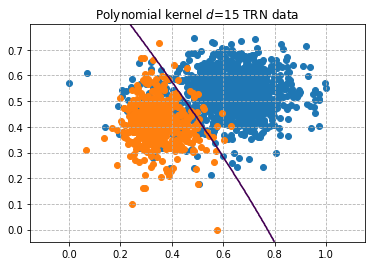

In [15]:
C = best_params[0]
d = best_params[1]

options = {'verb': False, 't_max': float('inf'),
           'kernel': 'polynomial', 'd': d}
model = my_kernel_svm(X_trn, y_trn, C, options)
plot_points(X_trn, y_trn)
plt.axis('equal')
plt.grid(linestyle='--')
plt.title('Polynomial kernel $d$={} TRN data'.format(d))
plot_boundary(plt.gca(), model)

In [16]:
data = np.load("ocr_data_2D_tst.npz", allow_pickle=True)
X_tst = data['X']
y_tst = data['y']
images_tst = data['images']

In [17]:
classif = classif_kernel_svm(X_tst, model)
err = np.mean(classif != y_tst)
print('err')

err


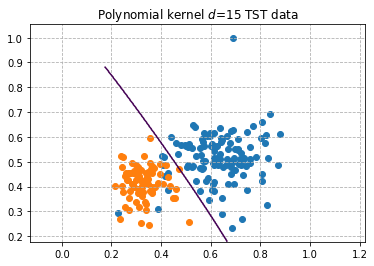

In [18]:
plot_points(X_tst, y_tst)
plt.axis('equal')
plt.grid(linestyle='--')
plt.title('Polynomial kernel $d$={} TST data'.format(d))
plot_boundary(plt.gca(), model)
plt.savefig('ocr_polynomial_kernel_tst.png')

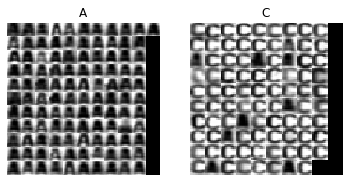

In [19]:
labels = classif.copy()
labels[labels == 1] = 0
labels[labels == -1] = 1

plt.figure()
show_classification(images_tst, labels, 'AC')
plt.savefig('ocr_svm_classif.png')

# Part 3: Real world example - digit classification

In [20]:
data = np.load("mnist_trn.npz", allow_pickle=True)
X_trn = data['X']
y_trn = data['y']

In [21]:
np.random.seed(42)
trn_folds, tst_folds = crossval(y_trn.size, num_folds=5)
Cs = [0.01, 0.1, 1, 10]
sigmas = [0.5, 0.9, 1.5]

best_params = None
best_err = np.inf
for C in Cs:
    for sigma in sigmas:
        options = {'verb': False, 't_max': float('inf'),
                   'kernel': 'rbf', 'sigma': sigma}
        err = compute_kernel_test_error(trn_folds, tst_folds, X_trn, y_trn, C, options)

        if err < best_err:
            best_err = err
            best_params = (C, sigma)
        print('C {}, sigma {} -> err {}'.format(C, sigma, err))

print('best params: C={}, sigma={}'.format(best_params[0], best_params[1]))

C 0.01, sigma 0.5 -> err 0.465
C 0.01, sigma 0.9 -> err 0.465
C 0.01, sigma 1.5 -> err 0.465
C 0.1, sigma 0.5 -> err 0.465
C 0.1, sigma 0.9 -> err 0.465
C 0.1, sigma 1.5 -> err 0.465
C 1, sigma 0.5 -> err 0.25
C 1, sigma 0.9 -> err 0.2125
C 1, sigma 1.5 -> err 0.3725
C 10, sigma 0.5 -> err 0.5599999999999999
C 10, sigma 0.9 -> err 0.5599999999999999
C 10, sigma 1.5 -> err 0.5599999999999999
best params: C=1, sigma=0.9


In [22]:
C = best_params[0]
sigma = best_params[1]

options = {'verb': False, 't_max': float('inf'),
           'kernel': 'rbf', 'sigma': sigma}
model = my_kernel_svm(X_trn, y_trn, C, options)

In [23]:
data = np.load("mnist_tst.npz", allow_pickle=True)
X_tst = data['X']
y_tst = data['y']

In [24]:
classif = None
err = None
print('np.round(err, 8)')

np.round(err, 8)


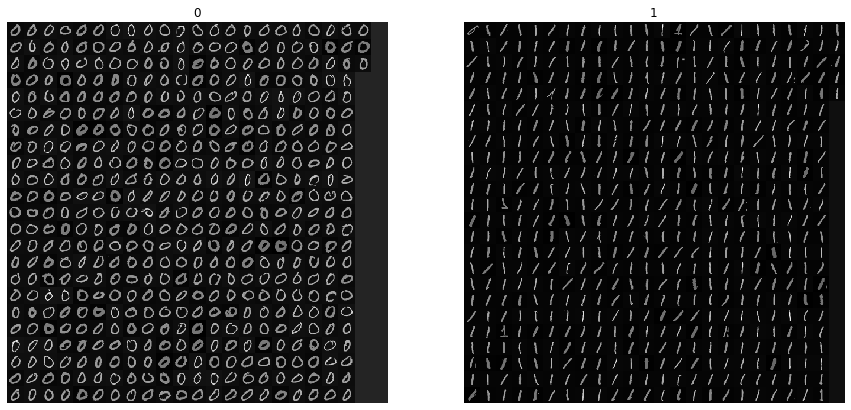

In [25]:
plt.figure(figsize=(15,10))
show_classification(X_tst.reshape(28,28,-1), classif > 0, '01')
plt.savefig('mnist_tst_classif.png')